## Convolution Calculator

Jake Bobowski<br>
October 21, 2024

Attempt to write a function that will discretize a pair of functions $f(x)$ and $g(x)$ and then calculate their convolution $(f*g)(t)$. In general, the convolution of a pair of continuous functions is defined by the following integral:
\begin{align}
(f*g)(t) &= \int_{-\infty}^\infty f(\tau)g(t - \tau)\,d\tau,\\
&=\int_{-\infty}^\infty g(\tau)f(t - \tau)\,d\tau.
\end{align}

The discretizing Eq. (1) allows us to write:
\begin{align}
(f*g)(t) &= \sum_{\tau = -T}^T  f(\tau)g(t - \tau)\,\Delta\tau,\nonumber\\
&= \sum_{n = -N}^N f(n\Delta\tau)g(t - n\Delta\tau)\,\Delta\tau
\end{align}
The limits of the sum have been chosen to span $\tau = -T$ to $T$ and we assume that both $f(t)$ and $g(t)$ are zero for all $\vert t\vert > T$.  We can express $T$ as $N\Delta\tau$, where $N$ and $\Delta\tau$ determine how finely we discretize our functions.

Explicitly writing out some of the terms of the sum leads to:
\begin{align}
(f*g)(t) &= \left\{f\left[-N\Delta\tau\right]g\left[t + N\tau\right] + f\left[(-N + 1)\Delta\tau\right]g\left[t - (-N + 1)\Delta\tau\right]+\dots\right. \nonumber\\
\nonumber\\
&+\left. f\left[-\Delta\tau\right]g\left[t +\Delta\tau\right] + f\left[0\right]g\left[t\right] + f\left[\Delta\tau\right]g\left[t -\Delta\tau\right] + \dots \right.\nonumber\\
\nonumber\\
&+\left. f\left[(N - 1)\Delta\tau\right]g\left[t - (N - 1)\Delta\tau\right] + f\left[N\Delta\tau\right]g\left[t - N\Delta\tau\right]\right\}\Delta\tau\nonumber
\end{align}

Initially, our calculation of the convolution will simply attempt to evaluate this sum for various values of $N$ and $\Delta\tau = T/N$.  Near the end of this notebook, we will briefly discuss and implement a much faster way to evaluate the convolution $(f*g)(t)$.

First, import some useful modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from IPython.display import display, clear_output

Here, we define a function that will:
 - we set the value of $N$.  The functions $f(t)$ and $g(t)$ that we'll use in this notebook and easiest to discretize if $N$ is divisble by four.  Whatever value of $N$ is entered is incremented by one until the final value of $N$ is divisible by four.  
 - define the domain of our functions to be $-T < t < T$, where $T = 4$.
 - determine the value of $\Delta\tau$
 - determine the list of $t$ values at which our functions $f(t)$ and $g(t)$ will ultimately be discretized.  Becaue we know that the convultion will require us to extend our time domain, we'll actually define our $t$ values such that they span $-2T$ to $+2T$.

In [2]:
def t_(N):
    # Ensure that N is a multiple of 4
    while N % 4 != 0:
        N += 1
    T_max = 4
    T_min = -4

    # Calculate dtau
    dtau = T_max/N
    
    # Define the set of x values
    t = []
    for i in range(4*N + 1):
        t = t + [(i - 2*N)*dtau]
    return N, t, dtau

Next, we define a function that creates out discretized $f(t)$ data.  We'll construct a triangular pulse that peaks at $f(0) = 4$ and goes to zero with a slope of $\pm 1$ as we move away from $t = 0$.

In [3]:
# Define the f(x) function
def  f_(t, N):
    f = []
    for i in range(N):
        f = f + [0]
    for i in range(N + 1):
        y = i - N
        f = f + [(N + y)/(2*N)*8]
    for i in range(N):
        y = i + 1
        f = f + [(N - y)/(2*N)*8]
    for i in range(N):
        f = f + [0]
    # print(f)
    plt.plot(t, f, 'ro')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    return f

Calling the function will construct that data and show the corresponding plot of $f(t)$ versus $t$.

Now we define a function for $g(t)$.

In [4]:
# Define the g(x) function
def g_(t, N):
    g = []
    for i in range(N):
        g = g + [0]
    for i in range(int(N/2)):
        g = g + [0]
    for i in range(int(N/2)):
        g = g + [1]
    g = g + [0]
    for i in range(int(N/2)):
        g = g + [-1]
    for i in range(int(N/2)):
        g = g + [0]
    for i in range(N):
        g = g + [0]
    # print(g)
    plt.plot(t, g, 'bo')
    plt.xlabel('t')
    plt.ylabel('g(t)')
    return g

Finally, define a function to acutally calculate the convolution $(f*g)(t)$.  There is also code included to optionally plot a visual representation of the what's being calculated as the convolution is iteratively calculated.

In [5]:
def fg_(t, f, g, plot = False, wait = 0.01):
    N = len(t)/4
    fg = [] # Empty list to store the values of the convolution
    start_time = time.time() # Start the timer
    for t1 in t: # Loop over the values of t
        tplt = [] # Empty list to store the values of t for the optional plot
        yplt = [] # Empty list to store the values of f(t) and g(t) for the optional plot
        tot = 0
        for tau in t: # Loop over the values of tau
            if (t1 - tau)/dtau >= -2*N and (t1 - tau)/dtau <= 2*N: # t - tau is within the domain of f and g
                k = 0
                while math.isclose(t[k], t1 - tau) == False: # Find the index of t1 - tau
                    k += 1
                t_tau = k
                tau_ = t.index(tau)
                tot = tot + f[tau_]*g[t_tau]
                if plot == True: # Determine the values of t and f(t), g(t) for the optional plot
                    if f[tau_] != 0 and g[t_tau] != 0:
                        tplt += [[t1 - tau, t1 - tau]]
                        yplt += [[f[tau_], g[t_tau]]]
        fg = fg + [tot*dtau] # Append the value of the convolution to the list fg
        if plot == True: # Plot the values of f(t), g(t) and the convolution
            plt.plot(t, f, 'ro')
            plt.plot(np.array(t) + t1, list(reversed(g)), 'bo') # Plot g(t) in reverse order, i.e.g(-t)
            plt.xlim(-16, 16)
            plt.xlabel('t')
            plt.ylabel('f(t), g(t)')
            for i in range(len(tplt)):
                plt.plot(t1 - np.array(tplt[i]), yplt[i], linestyle = ':', color = 'grey') # Plot lines connection points of f(t) g(t) that contribute to the convolution
            clear_output(wait = True)
            plt.pause(0.001)
            print('(f*g)(' + str(round(t1, 2)) + ') = ' + str(round(tot*dtau, 2))) # Print the value of the convolution at t = t1
            time.sleep(wait)
    end_time = time.time() 
    print('elapsed time: ' + str(round(end_time - start_time, 3)) + ' s.') # Print the elapsed time
    #print(x, fg)
    plt.plot(t, fg, 'go') # Plot the convolution (f*g)(t) vs t
    plt.xlabel('t')
    plt.ylabel('(f*g)(t)') 
    return fg

With all of the required functions defined, we can now actually evaluate $(f*g)(t)$.  Start by choosing a value for $N$, generating a list of $t$ values, and plotting discretized versions of $f(t)$ and $g(t)$.

We'll start with a small value of $N$.

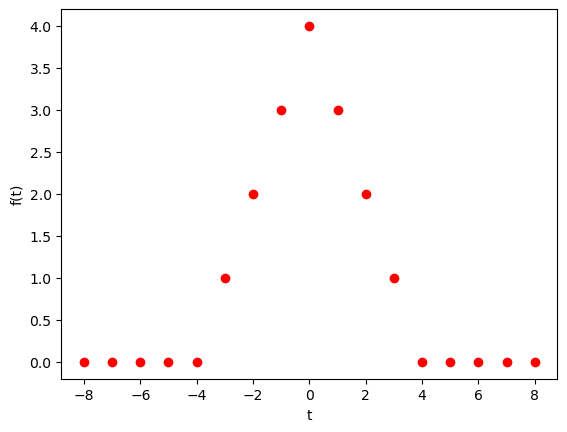

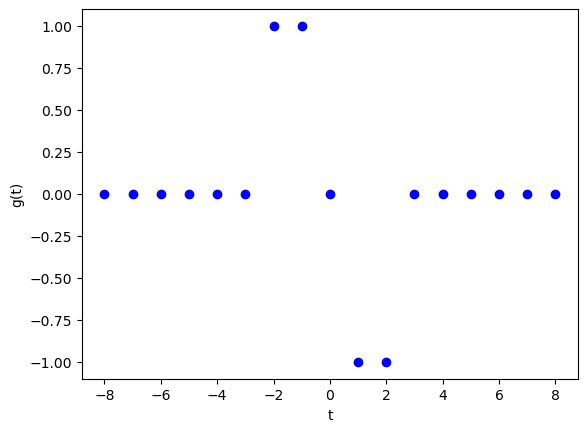

In [6]:
N = 4
N4, t, dtau = t_(N)
f = f_(t, N4)
plt.figure()
g = g_(t, N4)

We can now call the convolution fucntion ```fg_()```.  The function includes an option to plot $f(\tau)$ and $g(t - \tau)$ so as to highlight what is being calculated by the function.

Essentailly, $g(t)$ is reversed [$g(-\tau)$] and translated as the value of $t$ is varied.  When non-zero values of $f(\tau)$ and $g(t - \tau)$ overlap, they are multiplied.  For each value of $t$, the products from overlapping pairs of values are summed and multipled by $\Delta\tau$ to give ${(f*g)(t)}$.  

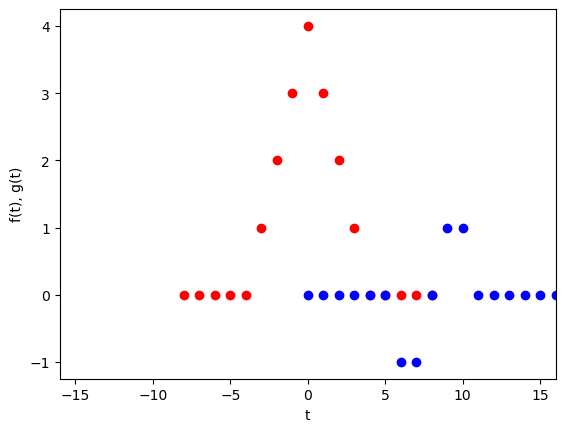

(f*g)(8.0) = 0.0
elapsed time: 20.912 s.


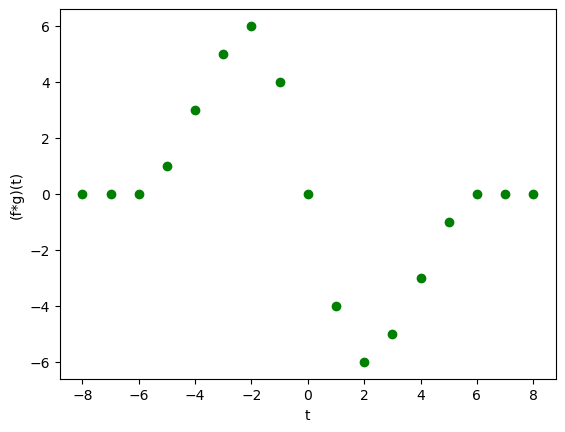

In [7]:
fg = fg_(t, f, g, plot = True, wait = 1)

Let's re-run the functions using a larger value of $N$.

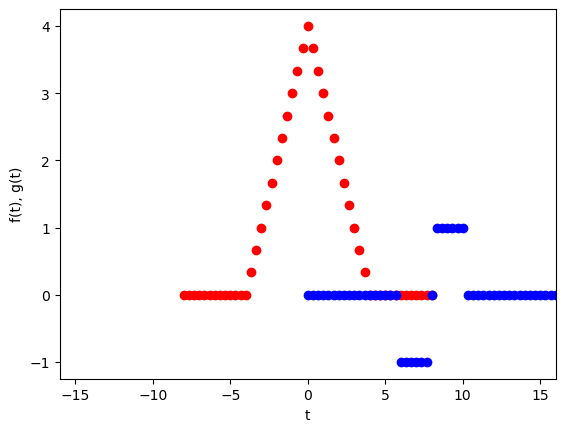

(f*g)(8.0) = 0.0
elapsed time: 12.118 s.


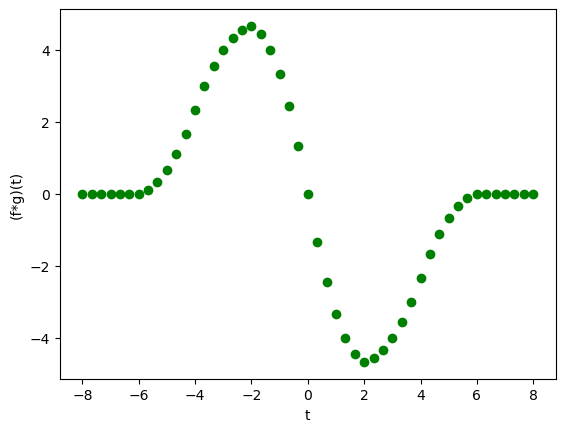

In [8]:
N = 9
N4, t, dtau = t_(N)
f = f_(t, N4)
plt.figure()
g = g_(t, N4)
plt.figure()
fg = fg_(t, f, g, plot = True, wait = 0.01)

The plots inside the loop slows down the calculation of $(f*g)(t)$.  Let's turn off the plotting and see how long it takes to evaluate the convolution for a moderate value of $N$.

elapsed time: 6.174 s.


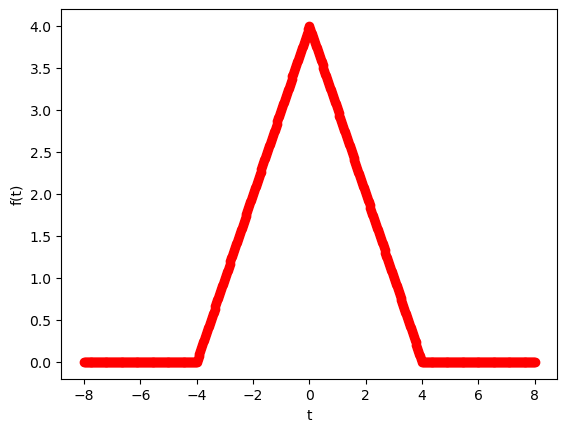

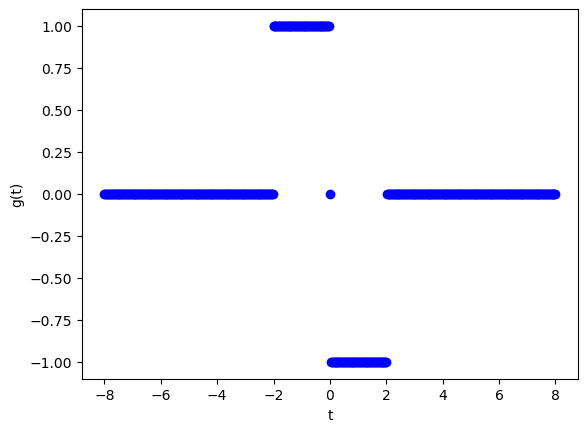

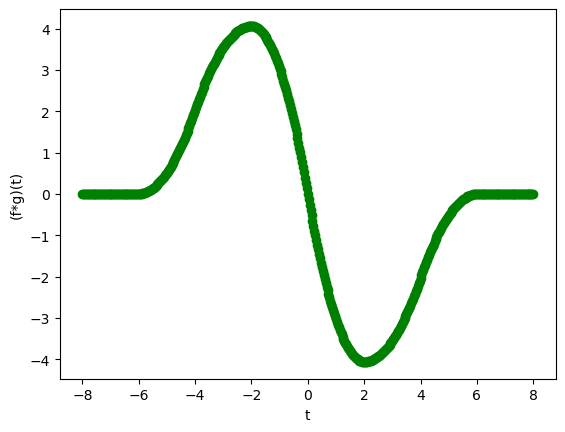

In [9]:
N = 120
N4, t, dtau = t_(N)
f = f_(t, N4)
plt.figure()
g = g_(t, N4)
plt.figure()
fg = fg_(t, f, g, plot = False)

Using $N = 120$, the calculation took about 7 s.

Let's see how long it takes Numpy's convolution function to do the same calculation.

elapsed time: 1243.83 us.


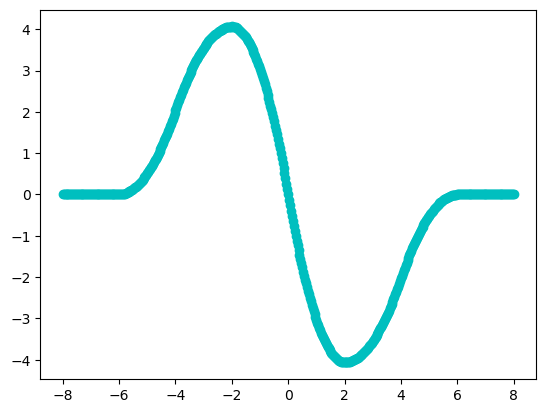

In [10]:
start_time = time.time()
fg_np = np.convolve(f, g, mode = 'same')
end_time = time.time()
print('elapsed time: ' + str(round((end_time - start_time)*1e6, 3)) + ' us.')
plt.plot(t, fg_np*dtau, 'co');

Numpy's calculation of $(f*g)(t)$ was several orders of magnitude faster than ours.  It is clearly using a different method for evaluating the convolution.

A hint comes from the connection between Fourier transforms and the convolution.  

If:
$$
\hat{y}(\omega) = \hat{f}(\omega)\hat{g}(\omega)\
$$
where:
\begin{align}
\hat{f}(\omega) &= \mathscr{F}\left[f(t)\right],\nonumber\\
\hat{g}(\omega) &= \mathscr{F}\left[g(t)\right].\nonumber
\end{align}
Then:
\begin{align}
y(t) &= \mathscr{F}^{-1}\left[\hat{f}(\omega)\hat{g}(\omega)\right]\nonumber\\
& = (f*g)(t).
\end{align}
Therefore, another way to find $(f*g)(t)$ is as follows:
 - First, Fourier transform $f(t)$ and $g(t)$ to determine $\hat{f}(\omega)$ and $\hat{g}(\omega)$
 - Then, evaluate the inverse Fourier transform of the product $\hat{f}(\omega)\hat{g}(\omega)$ to find $(f*g)(t)$
 A first glance, it doesn't seem like this second method would save time.  Afterall, we now have to evaluate three integrals instead of just the original convolution integral!

 The reason the second method turns out to be so much faster is that there is a Fast Fourier Transform algorythm (FFT) that is able to very quickly evaluate discrete Fourier transforms than inverse Fourier transforms.  If interested in the details of the FFT algorythm, there's an <a href = "https://www.youtube.com/watch?v=iTMn0Kt18tg&t=3s">MIT video</a> describing the method. 

 Here's a calculation of $(f*g)(t)$ using Numpy's FFT and inverse FFT functions.

elapsed time: 1244.545 us.


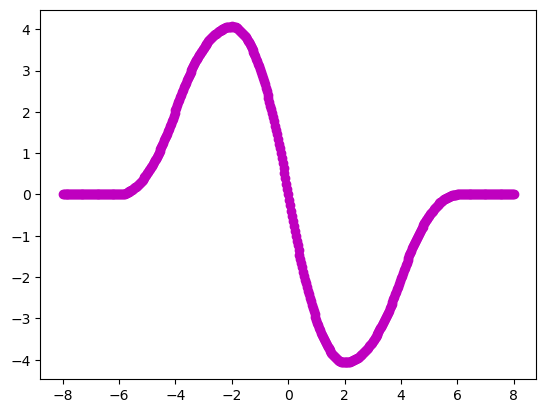

In [11]:
start_time = time.time() # Start the timer
f_hat = np.fft.fft(f) # Compute the Fourier transform of f
g_hat = np.fft.fft(g) # Compute the Fourier transform of g
fg2_ = np.fft.ifft(f_hat*g_hat) # Compute the inverse Fourier transform of the product of the Fourier transforms of f and g
fg2_ = np.concatenate((np.real(fg2_[2*N:4*N + 1]), np.real(fg2_[0:2*N]))) # Shift the values of fg2_ to match the values of t
end_time = time.time() # End the timer
print('elapsed time: ' + str(round((end_time - start_time)*1e6, 3)) + ' us.')
plt.plot(t, fg2_*dtau, 'mo'); # Plot the convolution (f*g)(t) vs t

Notice that the result for $(f*g)(t)$ matching the previous reults and the calculation time was at least comparable to the runtime of Numpy's convolution function. 